In [2]:
#Import Necessary Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

After completing the exploratory data analysis along with statistical analysis in the last portion to answer high level questions about the different subgroups of data across boroughs and age groups, proportion of different groups, and change over time. 

We also determined the variables that were statistically significant with regards to their relationship with diversion and capture rates and their individual correlation in the heatmap. We will now move on to apply machine learning techniques to see how our variables together can be used to predict recycling rates and determine feature importance at a multivariate level.

Below we will begin by loading the dataframe from the csv and creating the filtered dataframe with the specified X and Y variables that were narrowed through correlation and p-value analysis.

In [3]:
#Load in dataframes created in the Data Wrangling portion
df_2016 = pd.read_csv('recycling_districts_2016')

#Create list of all possible X-variables in dataframe, which are the columns that are NOT the rates
#Create list of all possible Y-variables in dataframe, which are the columns that ARE the rates
rec_x_variables = list(df_2016.columns[9:])
rec_y_rates = list(df_2016.columns[4:8])
del rec_y_rates[1:3]

#Create sublists of categories of variables - Economic, Community, Race, Age Groups
economic = ['poverty_rate', 'pct_bach_deg', 'unemployment_cd', 'mean_commute']
community = ['pct_hh_rent_burd', 'pct_clean_strts', 'count_public_schools', 'count_hosp_clinic']
race = ['pct_black_nh', 'pct_white_nh', 'pct_hispanic', 'pct_asian_nh']
age = ['minors_under20', 'youngadults_20-39', 'middleaged_40-59', 'senior_over60']
comb_var = economic + community + race + age

df_corr_x = df_2016[comb_var]
df_corr_xy = df_2016[rec_y_rates + comb_var]
df_corr_xy.rename(columns={"Diversion Rate-Total (Total Recycling / Total Waste)": "Diversion Rate", "Capture Rate-Total ((Total Recycling - Leaves (Recycling)) / (Max Paper + Max MGP))x100": "Capture Rate Total"}, inplace=True)

/Users/varunraja/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


With the dataframe with the statistically significant variables and recycling rates created in 'df_corr_xy', we can begin to create our feature and target matrices. Below we can define the 'feature' matrix created by dropping the target variables diversion and capture rate from the dataframe, and the target matrix by extracting the diversion and capture rate columns of the dataframe. 

Since their are two target variables, we will break them into two variables, Y and Y2, to differentiate and apply later.

In [4]:
#Feature Selection - Create Feature and Target Matrix
features = df_corr_xy.drop(['Diversion Rate', 'Capture Rate Total'], axis=1)

target = df_corr_xy[['Diversion Rate', 'Capture Rate Total']]

Y = df_corr_xy['Diversion Rate']
Y2 = df_corr_xy['Capture Rate Total']

While we reduced our features matrix from all the possible variables to the ones with statistical signficance, and aggregated the age group percentages into 4 groups, we still cannot be sure that all of the variables will be relevant when applying them to a machine learning algorithms such as linear regression or random forests.

As such, we can further improve a model's predictability by using feature selection tecniques in order to optimize the accuracy. Two of the methods we will implement and explore are recursive feature elimination and lasso regularization. 

We begin by using the recursive feature elimination technique, at iterative technique which measures the success of a particular model by adding and removing attributes to find the optimal number and combination of features based on the resulting accuracy metric. Below we will implement this by testing the features on a linear regression model and measuring success using the R-squared. 

In [5]:
#Find optimal number of features using Recursive Feature Elimination
#no of features
num_features_list = np.arange(1,17)            
high_score= 0

#Variable to store the optimum features
nof = 0           
score_list = []
for n in range(len(num_features_list)):
    X_train, X_test, y_train, y_test = train_test_split(features , target.iloc[:, 0], test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, num_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = num_features_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 12
Score with 12 features: 0.759062


We discover the optimum number of features determined by recursive feature elimination with linear regression is 12 with an R-squared score of .76. Below we will plug in this number into the RFE to find the features that were selected and their ranked importances.

In [6]:
#Plug in optimal number of features into RFE model to find relevant features and ranking 
cols = list(features.columns)
lr_model = LinearRegression()

#Initializing RFE model
rfe = RFE(lr_model, 12)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(features, target.iloc[:, 0])  

#Fitting the data to model
lr_model.fit(X_rfe, target.iloc[:, 0])              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index
features_lr = features[selected_features_rfe]
print(selected_features_rfe)

Index(['poverty_rate', 'pct_bach_deg', 'mean_commute', 'pct_clean_strts',
       'pct_black_nh', 'pct_white_nh', 'pct_hispanic', 'pct_asian_nh',
       'minors_under20', 'youngadults_20-39', 'middleaged_40-59',
       'senior_over60'],
      dtype='object')


Plugging in the optimal features of 12 into the RFE model, we discover which 12 features are important and stores those features into the 'features_lr' list. Below we will proceed to run a simple linear regression to predict the diversion rates. 

We begin by splitting the data into training and testing data, using a 10% testing holdout due to the limited number of data points in order to maximize training strength and predictability. We then fit the data and use 10-fold cross validation to find the best breakdown of testing and training data for the 10% holdout. Lastly we'll print the cross-validation scores and root mean squared error (RMSE) to evaluate the model. 

In [7]:
#Run Linear Regression Model Using Selected Features from RFE
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(features_lr , target.iloc[:, 0], test_size = 0.1, random_state = 0)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)
cv_scores = cross_val_score(lr, X_train, y_train, cv=10)
y_pred = lr.predict(X_test)
y_cross = cross_val_predict(lr, features_lr, target.iloc[:, 0], cv=10)
accuracy = metrics.r2_score(target.iloc[:, 0], y_cross)
cv_scores, np.mean(cv_scores), accuracy, np.sqrt(mean_squared_error(y_test, y_pred))

(array([ 0.59363285,  0.8311688 ,  0.8288749 ,  0.28978712,  0.95778418,
         0.75753376, -0.28778967,  0.59299006,  0.29775533,  0.62784842]),
 0.54895857598242437,
 0.62210808002979467,
 2.6596982623065535)

The results show a mean cross validation R-squared score of .55, which means that 55% of the variance of the data can be explained by the linear regression model built. This is an average across all the 10-folds of cross-validation. 

Moreover, after predicting the Y-values (diversion rates) from the test X data, we can compare that against the actual diversion rates held out in the y_test set to determine how closely the predictions matched the actual data. For this, we use the metric root mean squared error, which measures the average difference between the predicted rates and actual rates. 

Both these metrics are fairly strong, but ideally we'd like a root mean squared error (RMSE) closer to 0 and an R-squared score closer to 1.0. As such, we will evaluate the data through 3 more models in order to determine the best model that can predict diversion rate from the features available. 

The next model we'll attempt is a variation of linear regression using lasso regularization, which combines variable selection and regression to determine which variables are relevant by determining their coefficients and shrinking any that don't improve the model to 0.

Best alpha using built-in LassoCV: 1.199457
Best score using built-in LassoCV: 0.797443
Lasso picked 8 variables and eliminated the other 8 variables


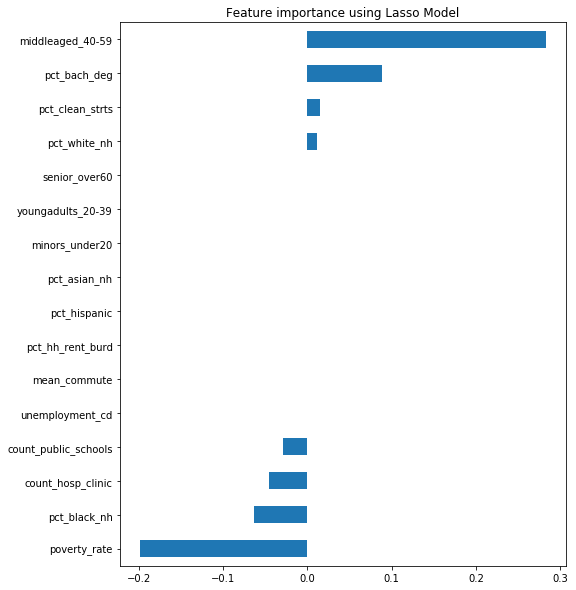

In [8]:
#Embedded Method using 16 variables

reg = LassoCV()
reg.fit(features, target.iloc[:, 0])
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(features, target.iloc[:, 0]))
coef = pd.Series(reg.coef_, index = features.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

As seen above, the lasso regularization yielded a fairly high R-squared score of .80 and also helped determine the feature importances of each of the variables, leaving 8 variables and eliminating the other 8 through shrinkage. Interesingly the highest postive and negative scored variables were percent middle aged and poverty rate

Below we'll plot the coefficients of the RFE regression model to see how the results compare

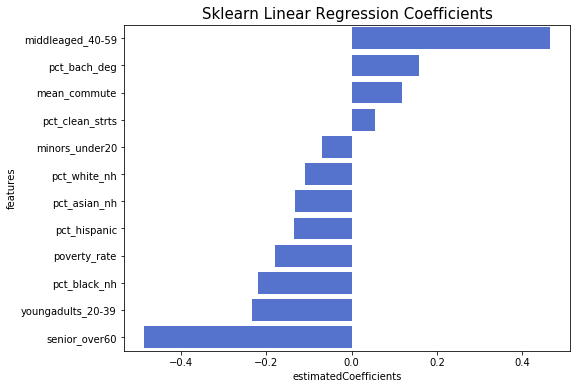

(             features  estimatedCoefficients
 0    middleaged_40-59               0.465265
 1        pct_bach_deg               0.158944
 2        mean_commute               0.117967
 3     pct_clean_strts               0.055974
 4      minors_under20              -0.069014
 5        pct_white_nh              -0.108791
 6        pct_asian_nh              -0.131884
 7        pct_hispanic              -0.135596
 8        poverty_rate              -0.179284
 9        pct_black_nh              -0.218886
 10  youngadults_20-39              -0.234190
 11      senior_over60              -0.485886, None)

In [11]:
# Plot the coefficients
lr_imp = pd.DataFrame({'features': features_lr.columns, 'estimatedCoefficients': lr.coef_})[['features', 'estimatedCoefficients']].sort_values('estimatedCoefficients', ascending = False).reset_index(drop = True)
sns.barplot(x = 'estimatedCoefficients', y = 'features', data = lr_imp, orient = 'h', color = 'royalblue').set_title('Sklearn Linear Regression Coefficients', fontsize = 15)
matplotlib.rcParams['figure.figsize'] = (8, 6)
lr_imp, plt.show()

#

The next technique we will evaluate is XGBOOST, which is uses the technique of gradient boosting which build a model and uses the results to improve the next model iteratively. Boosting can be done through decision tree regression or linear regression, and as such we will once again run the RFE to determine which features as relevant.

In [12]:
#Find optimal number of features using Recursive Feature Elimination
#no of features
num_features_list = np.arange(1,17)            
high_score= 0

#Variable to store the optimum features
nof = 0           
score_list = []
for n in range(len(num_features_list)):
    X_train, X_test, y_train, y_test = train_test_split(features, target.iloc[:, 0], test_size = 0.1, random_state = 0)
    model = xgb.XGBRegressor()
    rfe = RFE(model, num_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = num_features_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))        
        
#Plug in optimal number of features into RFE model to find relevant features and ranking 
cols = list(features.columns)
lr_model = LinearRegression()

#Initializing RFE model
rfe = RFE(lr_model, nof)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(features, target.iloc[:, 0])  

#Fitting the data to model
lr_model.fit(X_rfe, target.iloc[:, 0])              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe) 
features_xgb = features[selected_features_rfe]

[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Now that we've determined the optimum number of features to be 14 with a score of .82, we can build and test our model. One difference between the XGBOOST regressor compared to a simple linear regressor is that we have to input hyperparameters, such as using a linear or tree as booster and the number of estimators to evaluate. This can be tuned using gridsearch as shown below.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features_xgb , target.iloc[:, 0], test_size = 0.1, random_state = 0)


param_grid_xg = {'booster': ['gblinear', 'gbtree'], 'n_estimators': range(1, 20)} 
xg_grid = xgb.XGBRegressor()
xg_gridsearch = GridSearchCV(estimator= xg_grid, param_grid= param_grid_xg, cv=10)
xg_gridsearch.fit(X_train, y_train)
xg_gridsearch.best_score_, xg_gridsearch.best_estimator_

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt


[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is 

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

(0.47121158098360305,
 XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0,
        importance_type='gain', learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=18,
        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=None, subsample=1, verbosity=1))

After running the grid search, we've determined the optimal booster to be 'gblinear' and the optimal number of estimators to be '18' as they produce the best score. We can proceed to plug this into the model and find our predicted recycling rates.

In [14]:
##XGBOOST REGRESSION
xgb_reg = xgb.XGBRegressor(objective="reg:linear", booster="gblinear", n_estimators=18, seed=123)
xgb_reg.fit(X_train, y_train)
y_pred2 = xgb_reg.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
y_pred2, rmse2

[01:06:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(array([ 20.48784256,  22.92668724,  18.73782539,  11.05444908,
         14.86069393,  11.24664307], dtype=float32), 2.8611028311503053)

As seen above, after predicting the diversion rates through the XGB regressor we find a RMSE of 2.86 which is higher than the standard linear regression completed previously

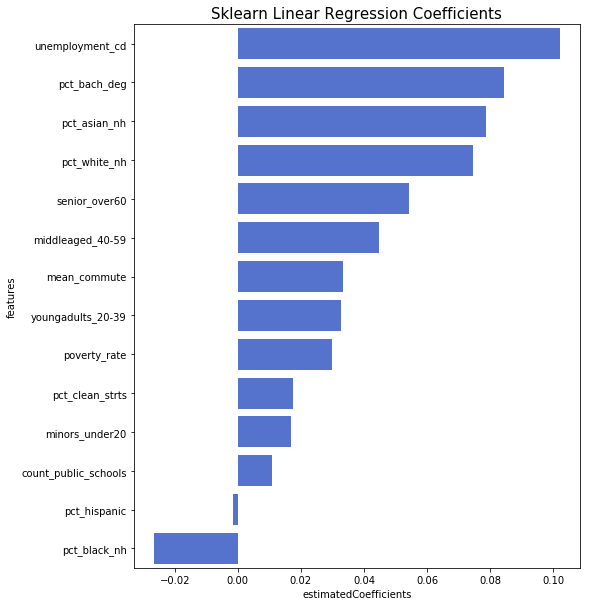

(                features  estimatedCoefficients
 0        unemployment_cd               0.102031
 1           pct_bach_deg               0.084416
 2           pct_asian_nh               0.078619
 3           pct_white_nh               0.074532
 4          senior_over60               0.054108
 5       middleaged_40-59               0.044824
 6           mean_commute               0.033495
 7      youngadults_20-39               0.032559
 8           poverty_rate               0.029737
 9        pct_clean_strts               0.017466
 10        minors_under20               0.016900
 11  count_public_schools               0.010715
 12          pct_hispanic              -0.001627
 13          pct_black_nh              -0.026549, None)

In [12]:
# The coefficients
xgb_imp = pd.DataFrame({'features': features_xgb.columns, 'estimatedCoefficients': xgb_reg.coef_})[['features', 'estimatedCoefficients']].sort_values('estimatedCoefficients', ascending = False).reset_index(drop = True)
sns.barplot(x = 'estimatedCoefficients', y = 'features', data = xgb_imp, orient = 'h', color = 'royalblue').set_title('Sklearn Linear Regression Coefficients', fontsize = 15)
xgb_imp, plt.show()

Lastly, we will attempt to use a random forest regressor, or a series of decision trees whose results are aggregated and averaged to increase the accuracy of the predictor. We begin this by once again applying the RFE to determine t he optimal combination of variables.

In [24]:
#Find optimal number of features using Recursive Feature Elimination
#no of features
num_features_list = np.arange(1,17)            
high_score= 0

#Variable to store the optimum features
nof = 0           
score_list = []
for n in range(len(num_features_list)):
    X_train, X_test, y_train, y_test = train_test_split(features, target.iloc[:, 0], test_size = 0.3, random_state = 0)
    model = RandomForestRegressor(random_state=0)
    rfe = RFE(model, num_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = num_features_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))        
        
#Plug in optimal number of features into RFE model to find relevant features and ranking 
cols = list(features.columns)
lr_model = LinearRegression()

#Initializing RFE model
rfe = RFE(lr_model, nof)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(features, target.iloc[:, 0])  

#Fitting the data to model
lr_model.fit(X_rfe, target.iloc[:, 0])              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe) 
features_rf = features[selected_features_rfe]

Optimum number of features: 15
Score with 15 features: 0.804728
Index(['poverty_rate', 'pct_bach_deg', 'unemployment_cd', 'mean_commute',
       'pct_hh_rent_burd', 'pct_clean_strts', 'count_public_schools',
       'pct_black_nh', 'pct_white_nh', 'pct_hispanic', 'pct_asian_nh',
       'minors_under20', 'youngadults_20-39', 'middleaged_40-59',
       'senior_over60'],
      dtype='object')


The RFE application to the random forest regressor suggests an optimal number of features of 15 yielding a score of 0.804728. We will proceed to apply that breakdown into our train-test split and run a gridsearch to determine the optimal number of branches, maximum depth, and estimators.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features_rf , target.iloc[:, 0], test_size = 0.1, random_state = 0)

param_grid = {'max_depth': range(5, 50, 5), 'n_estimators': range(1, 20)} 
rand_forest_grid = RandomForestRegressor()
rf_gridsearch = GridSearchCV(estimator=rand_forest_grid, param_grid=param_grid, cv=10)
rf_gridsearch.fit(X_train, y_train)
rf_gridsearch.best_score_, rf_gridsearch.best_estimator_

(0.54426140289881542,
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False))

In [26]:
##RANDOM FOREST Regression
rand_forest = RandomForestRegressor(n_estimators=13, random_state=123, max_depth=45)
rand_forest.fit(X_train, y_train)
y_pred4 = rand_forest.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred4))

2.3683870326034655

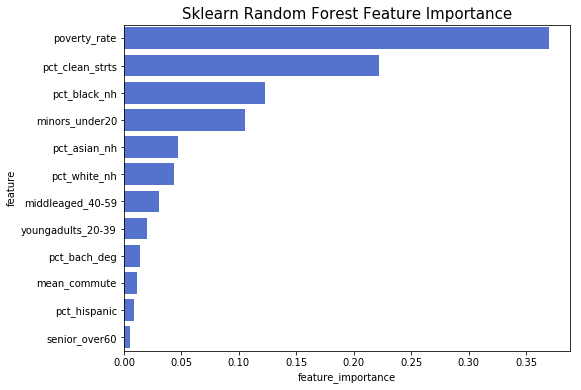

(              feature  feature_importance
 0        poverty_rate            0.369827
 1     pct_clean_strts            0.222100
 2        pct_black_nh            0.123097
 3      minors_under20            0.105527
 4        pct_asian_nh            0.046930
 5        pct_white_nh            0.043236
 6    middleaged_40-59            0.030576
 7   youngadults_20-39            0.019849
 8        pct_bach_deg            0.013648
 9        mean_commute            0.011304
 10       pct_hispanic            0.008896
 11      senior_over60            0.005010, None)

In [26]:
df_feature_importance = pd.DataFrame({'feature': X_train.columns,
                       'feature_importance': rand_forest.feature_importances_}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        
sns.barplot(x = 'feature_importance', y = 'feature', data = df_feature_importance, orient = 'h', color = 'royalblue').set_title('Sklearn Random Forest Feature Importance', fontsize = 15)
        
df_feature_importance, plt.show()

In [27]:
#Compare models through RMSE and R^2 scores
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred2))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred4))
print("Root Mean Squared Error - Linear Regression:", rmse_lr)
print("Root Mean Squared Error - XGBoost:", rmse_xg)
print("Root Mean Squared Error - Random Forest:", rmse_rf)

Root Mean Squared Error - Linear Regression: 2.65969826231
Root Mean Squared Error - XGBoost: 2.86110283115
Root Mean Squared Error - Random Forest: 2.3683870326


In [28]:
print("R-Squared Score - Linear Regression:", np.mean(cv_scores))
print("R-Squared Score - XGBoost:", xg_gridsearch.best_score_)
print("R-Squared Score - Random Forest:", rf_gridsearch.best_score_)

R-Squared Score - Linear Regression: 0.548958575982
R-Squared Score - XGBoost: 0.471211580984
R-Squared Score - Random Forest: 0.544261402899


1. RFE feature selection - linear regression
2. RFE application to linear regression - save scores
3. Lasso Regularion selection - save scores
4. RFE feature selection - XGBoost
5. Grid search - XGBOost
6. XGBoost application and score
7. RFE feature selection - Random Forest
8. Grid search - Random Forest
9. Random forest application and score
10. Feature importances for each and analysis
11. Compare models using RMSE and R^2 and explain choice